In [1]:
import keras
from keras.models import Sequential, Model, load_model

import os
import pickle
import numpy as np
import pandas as pd

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from scrambler.models.scrambler_models_w_diff import *
from scrambler.utils import OneHotEncoder, get_sequence_masks
from scrambler.visualizations import plot_dna_logo, plot_dna_importance_scores


Using TensorFlow backend.


In [2]:
#Variant data parameters

isoform_pseudo_count = 1.
proximal_start = 77
proximal_end = 107#127


In [3]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode_no_drop'

save_dir = os.path.join(os.getcwd(), '../../../../autoscrambler/analysis/apa/saved_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)

#Re-define model for variant lor prediction
ref_input = Input(name="ref_input", shape=(1, 205, 4))
var_input = Input(name="var_input", shape=(1, 205, 4))
l_input = Input(name="l_input", shape=(13,))

ref_cut = aparent_model([ref_input, l_input])[1]
var_cut = aparent_model([var_input, l_input])[1]

def _lor(inp, iso_start=proximal_start, iso_end=proximal_end) :

    cuts_ref, cuts_var = inp
    
    y_ref = K.sum(cuts_ref[:, iso_start:iso_end], axis=-1)[:, None]
    y_var = K.sum(cuts_var[:, iso_start:iso_end], axis=-1)[:, None]
    
    y_ref = K.clip(y_ref, K.epsilon(), 1.0 - K.epsilon())
    y_var = K.clip(y_var, K.epsilon(), 1.0 - K.epsilon())

    lor = K.log(y_var / (1. - y_var)) - K.log(y_ref / (1. - y_ref))

    return lor

lor_pred = Lambda(_lor, name='lor')([ref_cut, var_cut])

predictor = Model(
    inputs=[ref_input, var_input, l_input],
    outputs=[lor_pred]
)

predictor.trainable = False

predictor.compile(
    optimizer=keras.optimizers.SGD(lr=0.1),
    loss='mean_squared_error'
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
#Load GT-rich variant data

data_df = pd.read_csv("apa_mpra_variants_dse_gt_rich_gain_w_cutsite.csv", sep='\t')

data_df = data_df.query("delta_logodds_true > 0.5 and delta_logodds_pred > 0.5")
data_df = data_df.loc[data_df['gene'].isin(["RB1.10", "MOCS2.2", "SMAD4.5"])]

data_df = data_df.sort_values(by='delta_logodds_pred', ascending=False)

data_df = data_df.drop_duplicates(subset=['gene'], keep='first').copy().reset_index(drop=True)

data_df['wt_seq'] = "ACACGACGCTCTTCCGATCT" + data_df['wt_seq'] + "GGAGCAGATACTGGCTTAACT"
data_df['master_seq'] = "ACACGACGCTCTTCCGATCT" + data_df['master_seq'] + "GGAGCAGATACTGGCTTAACT"

print("len(data_df) = " + str(len(data_df)))


len(data_df) = 3


In [5]:

data_df[['gene', 'delta_logodds_true', 'delta_logodds_pred', 'clinvar_id', 'significance']]


,gene,delta_logodds_true,delta_logodds_pred,clinvar_id,significance
0,RB1.10,0.581111,0.927460,Missing,Missing
1,MOCS2.2,1.320972,0.688293,NM_002203.3(ITGA2):c.*3986A>C,Benign
2,SMAD4.5,0.641447,0.553592,Missing,Missing


In [6]:
#Generate training and test set indexes

#Load data matrices
encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

x_ref_sel = np.concatenate([encoder(row['wt_seq'])[None, None, ...] for _, row in data_df.iterrows()], axis=0)
x_var_sel = np.concatenate([encoder(row['master_seq'])[None, None, ...] for _, row in data_df.iterrows()], axis=0)

l_sel = np.zeros((x_ref_sel.shape[0], 13))
l_sel[:, 11] = 1.

b_sel = np.max(np.abs(x_ref_sel - x_var_sel), axis=-1, keepdims=True) * 50.

y_true_sel = np.reshape(data_df['delta_logodds_true'].values, (len(data_df), 1))
y_pred_sel = np.reshape(data_df['delta_logodds_pred'].values, (len(data_df), 1))

print("x_ref_sel.shape = " + str(x_ref_sel.shape))
print("x_ref_sel.shape = " + str(x_ref_sel.shape))
print("l_sel.shape = " + str(l_sel.shape))
print("y_true_sel.shape = " + str(y_true_sel.shape))

#Overwrite with new resnet lor predictions

y_pred_sel = predictor.predict(x=[x_ref_sel, x_var_sel, l_sel], batch_size=32, verbose=True)


x_ref_sel.shape = (3, 1, 205, 4)
x_ref_sel.shape = (3, 1, 205, 4)
l_sel.shape = (3, 13)
y_true_sel.shape = (3, 1)
3/3 [==============================] - 2s 663ms/step


In [7]:
#Define sequence template and background

sequence_template = 'ACACGACGCTCTTCCGATCT$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$$GGAGCAGATACTGGCTTAACT'

pseudo_count = 1.0

onehot_template = encoder(sequence_template)[None, ...]
sequence_mask = get_sequence_masks([sequence_template])[0]

x_mean = np.zeros((205, 4))

#Set uniform background
x_mean[:, :] = 0.25


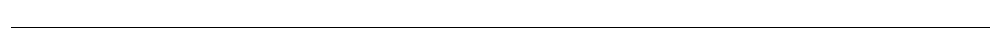

In [8]:
#Visualize background sequence distribution

plot_dna_logo(np.copy(x_mean), sequence_template=sequence_template, figsize=(14, 0.65), logo_height=1.0, plot_start=0, plot_end=205)


In [9]:
#Calculate biased, example-specific backgrounds

pseudo_count = 1.0

x_mean_sel = (x_ref_sel[:, 0, ...] + pseudo_count) / (1. + 4. * pseudo_count)

#Lock background across CSE
x_mean_sel[:, 70:76, :] = np.clip(x_ref_sel[:, 0, 70:76, :], 1e-7, 1. - 1e-7)

group_sel = np.arange(x_mean_sel.shape[0])[:, None]


In [10]:
#Run optimization with bias turned on across CSE, to reduce variance further

cse_bias = np.zeros((1, 1, 205, 1))
cse_bias[:, :, 70:76, :] = 50.


In [11]:
#Build scrambler

#Scrambler network configuration
network_config = {
    'n_groups' : 5,
    'n_resblocks_per_group' : 4,
    'n_channels' : 32,
    'window_size' : 3,
    'dilation_rates' : [1, 2, 4, 2, 1],
    'drop_rate' : 0.0,
    'norm_mode' : 'instance',
    'mask_smoothing' : False,
    'mask_smoothing_window_size' : 5,
    'mask_smoothing_std' : 1.,
    'mask_drop_scales' : [1, 5],
    'mask_min_drop_rate' : 0.0,
    'mask_max_drop_rate' : 0.5,
    'label_input' : False
}

#Initialize scrambler
scrambler = Scrambler(
    n_inputs=2,
    scrambler_mode='inclusion',
    input_size_x=1,
    input_size_y=205,
    n_out_channels=4,
    input_templates=[onehot_template for k in range(x_ref_sel.shape[0])],
    input_backgrounds=[x_mean_sel[k, :, :] for k in range(x_ref_sel.shape[0])],
    batch_size=1,
    n_samples=128,
    multi_input_mode='shared',
    sample_mode='gumbel',
    gumbel_temp=0.1,
    zeropad_input=False,
    mask_dropout=False,
    network_config=network_config,
    subset_size=None
)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [12]:
#Round 1: Pre-training

[pwm_ref_sel_pre, pwm_var_sel_pre], [sample_ref_sel_pre, sample_var_sel_pre], [scores_sel_pre, _], pretrain_histories = scrambler.optimize(
    predictor,
    [x_ref_sel, x_var_sel],
    np.zeros((x_ref_sel.shape[0], 1)),
    bias=[b_sel + cse_bias],
    extra_input=[l_sel],
    group=[group_sel, group_sel],
    batch_size=1,
    n_iters=100,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='target',
    entropy_bits=0.5,
    entropy_weight=1.,
    subset_size=None,
    cache_prefix_path='saved_models/apa_gt_vars',
    load_from_cache=False,
)

#Round 2: Fine-tuning

[pwm_ref_sel_fine, pwm_var_sel_fine], [sample_ref_sel_fine, sample_var_sel_fine], [scores_sel_fine, _], finetune_histories = scrambler.optimize(
    predictor,
    [x_ref_sel, x_var_sel],
    np.zeros((x_ref_sel.shape[0], 1)),
    bias=[b_sel + cse_bias],
    extra_input=[l_sel],
    group=[group_sel, group_sel],
    batch_size=1,
    n_iters=300,
    norm_mode='instance',
    adam_lr=0.01,
    adam_beta_1=0.5,
    adam_beta_2=0.9,
    nll_mode='reconstruction',
    predictor_task='regression',
    entropy_mode='maximization',
    entropy_bits=0.0,
    entropy_weight=0.3,
    subset_size=None,
    cache_prefix_path='saved_models/apa_gt_vars',
    load_from_cache=True,
)


Optimizing batch 0...
Epoch 1/1
100/100 [==============================] - 112s 1s/step - loss: 0.0236 - ft_nll_loss: 0.0232 - ft_entropy_loss: 3.7013e-04
Epoch 1/1
100/100 [==============================] - 103s 1s/step - loss: 0.0900 - ft_nll_loss: 0.0892 - ft_entropy_loss: 8.0988e-04
Epoch 1/1
100/100 [==============================] - 76s 758ms/step - loss: 0.0375 - ft_nll_loss: 0.0369 - ft_entropy_loss: 5.8766e-04
Optimizing batch 0...
Epoch 1/1
300/300 [==============================] - 320s 1s/step - loss: 0.0812 - ft_nll_loss: 0.0170 - ft_entropy_loss: 0.0642
Epoch 1/1
300/300 [==============================] - 312s 1s/step - loss: 0.0948 - ft_nll_loss: 0.0273 - ft_entropy_loss: 0.0675
Epoch 1/1
300/300 [==============================] - 286s 955ms/step - loss: 0.0789 - ft_nll_loss: 0.0327 - ft_entropy_loss: 0.0462


In [12]:
#Cache interpretations

save_suffix = '_per_example_no_drop_inference_mode_gt_vars'
'''
#Store interpretations
pickle.dump({
    'pwm_ref_sel_pre' : pwm_ref_sel_pre,
    'pwm_var_sel_pre' : pwm_var_sel_pre,

    'sample_ref_sel_pre' : sample_ref_sel_pre,
    'sample_var_sel_pre' : sample_var_sel_pre,

    'scores_sel_pre' : scores_sel_pre,
    
    'pwm_ref_sel_fine' : pwm_ref_sel_fine,
    'pwm_var_sel_fine' : pwm_var_sel_fine,

    'sample_ref_sel_fine' : sample_ref_sel_fine,
    'sample_var_sel_fine' : sample_var_sel_fine,

    'scores_sel_fine' : scores_sel_fine,
}, open('apa_variants_mpra_interpretations_sel' + save_suffix + '.pickle', 'wb'))
'''
#Load interpretations
cache_dict = pickle.load(open('apa_variants_mpra_interpretations_sel' + save_suffix + '.pickle', 'rb'))

pwm_ref_sel_pre = cache_dict['pwm_ref_sel_pre']
pwm_var_sel_pre = cache_dict['pwm_var_sel_pre']

sample_ref_sel_pre = cache_dict['sample_ref_sel_pre']
sample_var_sel_pre = cache_dict['sample_var_sel_pre']

scores_sel_pre = cache_dict['scores_sel_pre']

pwm_ref_sel_fine = cache_dict['pwm_ref_sel_fine']
pwm_var_sel_fine = cache_dict['pwm_var_sel_fine']

sample_ref_sel_fine = cache_dict['sample_ref_sel_fine']
sample_var_sel_fine = cache_dict['sample_var_sel_fine']

scores_sel_fine = cache_dict['scores_sel_fine']


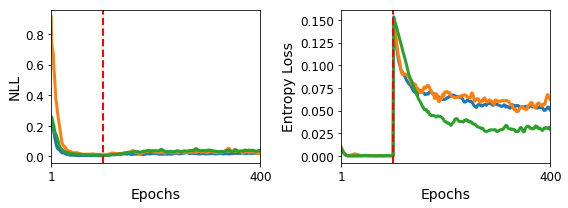

In [14]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(2 * 4, 3))

n_epochs_actual = len(pretrain_histories[0]['ft_nll']) + len(finetune_histories[0]['ft_nll'])

n_epochs_pretrain = len(pretrain_histories[0]['ft_nll'])
n_epochs_finetune = len(finetune_histories[0]['ft_nll'])

nll_rolling_window = 5
entropy_rolling_window = 1

for i in range(len(pretrain_histories)) :
    ax1.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_nll']), np.array(finetune_histories[i]['ft_nll'])], axis=0), window=nll_rolling_window), linewidth=3)

ax1.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax1)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("NLL", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

for i in range(len(pretrain_histories)) :
    ax2.plot(np.arange(1, n_epochs_actual + 1), _rolling_average(np.concatenate([np.array(pretrain_histories[i]['ft_entropy']), np.array(finetune_histories[i]['ft_entropy'])], axis=0), window=entropy_rolling_window), linewidth=3)

ax2.axvline(x=n_epochs_pretrain, linewidth=2, color='red', linestyle='--')

plt.sca(ax2)
plt.xlabel("Epochs", fontsize=14)
plt.ylabel("Entropy Loss", fontsize=14)
plt.xlim(1, n_epochs_actual)
plt.xticks([1, n_epochs_actual], [1, n_epochs_actual], fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()

plt.show()


In [13]:
#Mask out USE and DSE regions (do not consider CSE)
sequence_mask_no_cse = np.copy(sequence_mask)
sequence_mask_no_cse[70:76] = 0.

#Subtract biases
scores_sel_fine = scores_sel_fine - b_sel - cse_bias

scores_sel_fine *= sequence_mask_no_cse[None, None, :, None]

#Normalize to max score = 1
scores_sel_fine /= np.max(scores_sel_fine, axis=(1, 2, 3), keepdims=True)


In [14]:
#Cache scores
save_name = 'apa_vars_gt_resnet_mpra_scrambler_shared'

np.save(save_name + '_ref_scores', scores_sel_fine)
np.save(save_name + '_var_scores', scores_sel_fine)
np.save(save_name + '_scores', scores_sel_fine)

#Load scores

scores_sel_fine = np.load(save_name + '_scores.npy')


Sequence 0:
PAS ID RB1.10:
ClinVar ID Missing:
Significance Missing:
 - Prediction (original) = 0.9360
 - Prediction (scrambled) = 0.8825
 - Measured = 0.5811


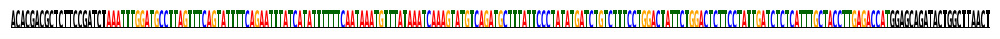

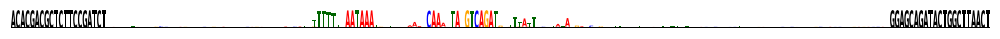

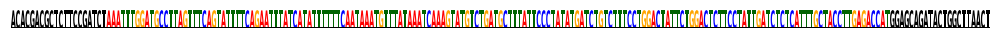

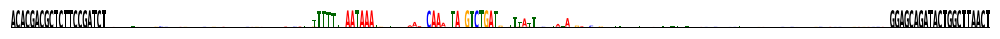

Net Scores:


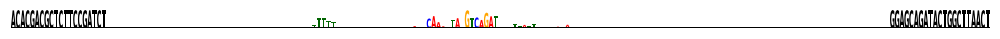

Sequence 1:
PAS ID MOCS2.2:
ClinVar ID NM_002203.3(ITGA2):c.*3986A>C:
Significance Benign:
 - Prediction (original) = 0.6842
 - Prediction (scrambled) = 0.5190
 - Measured = 1.3209


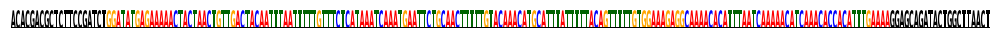

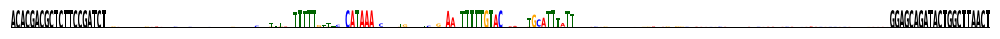

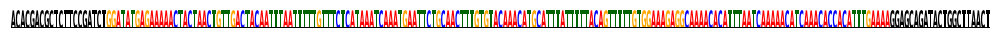

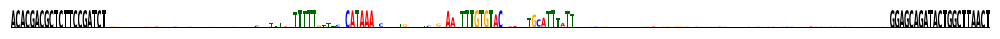

Net Scores:


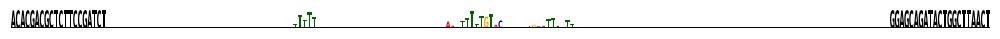

In [15]:
#Visualize a few reconstructed sequence patterns

model_name = "apa_vars_resnet_mpra_scrambler_shared_gt_vars"

plot_examples = [0, 1]
save_examples = []#[0, 1]

q_thresh = 1.0#0.95

for plot_i in range(x_ref_sel.shape[0]) :
    
    if plot_i not in plot_examples :
        continue
    
    print("Sequence " + str(plot_i) + ":")
    print("PAS ID " + data_df.iloc[plot_i]['gene'] + ":")
    print("ClinVar ID " + data_df.iloc[plot_i]['clinvar_id'] + ":")
    print("Significance " + data_df.iloc[plot_i]['significance'] + ":")
    
    lor_sel = predictor.predict(x=[x_ref_sel[plot_i:plot_i+1], x_var_sel[plot_i:plot_i+1], l_sel[plot_i:plot_i+1]], batch_size=1)[0, 0]
    lor_scrambled_sel_fine = np.mean(predictor.predict(x=[sample_ref_sel_fine[plot_i], sample_var_sel_fine[plot_i], np.tile(l_sel[plot_i:plot_i+1], (sample_ref_sel_fine.shape[1], 1))], batch_size=32)[:, 0])
    
    print(" - Prediction (original) = " + str(round(lor_sel, 6))[:6])
    print(" - Prediction (scrambled) = " + str(round(lor_scrambled_sel_fine, 6))[:6])
    
    print(" - Measured = " + str(round(data_df.iloc[plot_i]['delta_logodds_true'], 6))[:6])
    
    save_figs = False
    if save_examples is not None and plot_i in save_examples :
        save_figs = True
    
    score_clip = np.quantile(scores_sel_fine[plot_i, 0, :, :], q=q_thresh)
    
    plot_dna_logo(x_ref_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref")
    plot_dna_logo(pwm_ref_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_ref" + "_pwm")
    
    plot_dna_logo(x_var_sel[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var")
    plot_dna_logo(pwm_var_sel_fine[plot_i, 0, :, :], sequence_template=sequence_template, figsize=(14, 0.65), plot_start=0, plot_end=205, plot_sequence_template=True, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_var" + "_pwm")
    
    print("Net Scores:")
    plot_dna_importance_scores(scores_sel_fine[plot_i, 0, :, :].T, encoder.decode(x_ref_sel[plot_i, 0, :, :]), figsize=(14, 0.65), score_clip=score_clip, sequence_template=sequence_template, plot_start=0, plot_end=205, save_figs=save_figs, fig_name=model_name + "_sel_ix_" + str(plot_i) + "_scores")


In [15]:
#Load APARENT Resnet

model_name = 'aparent_all_libs_resnet_no_clinvar_wt_ep_5_var_batch_size_inference_mode'

save_dir = os.path.join(os.getcwd(), '../../../../autoscrambler/analysis/apa/saved_models')
model_path = os.path.join(save_dir, model_name + '.h5')

aparent_model = load_model(model_path)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [16]:
#Load human 3' UTR background distribution (from PolyaDB V3)

x_mean = np.load("../../../../aparent-resnet/analysis/polyadb_v3_utr3_background.npy")

print("x_mean.shape = " + str(x_mean.shape))


x_mean.shape = (205, 4)


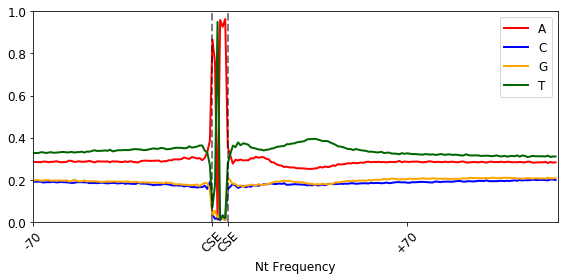

In [17]:
#Plot nt background frequencies across PAS

f = plt.figure(figsize=(8, 4))

l1 = plt.plot(np.arange(205), x_mean[:, 0], color='red', linewidth=2, label='A')
l2 = plt.plot(np.arange(205), x_mean[:, 1], color='blue', linewidth=2, label='C')
l3 = plt.plot(np.arange(205), x_mean[:, 2], color='orange', linewidth=2, label='G')
l4 = plt.plot(np.arange(205), x_mean[:, 3], color='darkgreen', linewidth=2, label='T')

plt.axvline(x=70, color='black', linewidth=2, linestyle='--', alpha=0.5)
plt.axvline(x=76, color='black', linewidth=2, linestyle='--', alpha=0.5)

plt.legend(handles=[l1[0], l2[0], l3[0], l4[0]], fontsize=12)

plt.xticks([0, 70, 76, 146], ['-70', 'CSE', 'CSE', '+70'], fontsize=12, rotation=45)
plt.yticks(fontsize=12)

plt.xlabel("Position", fontsize=12)
plt.xlabel("Nt Frequency", fontsize=12)

plt.xlim(0, 205)
plt.ylim(0, 1)

plt.tight_layout()

plt.show()


In [21]:
#Mask interpretations (CSEs)

plot_examples = [0, 1]

include_regions = [
    [76, 94],
    [76, 94],
]

for ix in plot_examples :

    gene = data_df.iloc[ix]['gene'].split(".")[0]
    gene_id = data_df.iloc[ix]['gene']
    chrom = "missing"
    strand = "."
    var_position = -1
    rel_var_position = np.argmax(b_sel[ix, 0, :, 0])
    pas_pos = -1
    snp_id = data_df.iloc[ix]['clinvar_id']
    ref_nucleotide = "?"
    var_nucleotide = "?"
    rel_ref_nucleotide = data_df.iloc[ix]['wt_seq'][data_df.iloc[ix]['snv_pos']+20]
    rel_var_nucleotide = data_df.iloc[ix]['master_seq'][data_df.iloc[ix]['snv_pos']+20]
    data_source = 'gt'
    experiment = 'interaction'

    #Get hard mask
    score_thresh = 0.1#0.2
    mask = np.array(scores_sel_fine[ix, 0, :, 0] > score_thresh, dtype=np.int)

    no_gaps = True
    no_single_nt = True

    if no_gaps :    
        for j in range(mask.shape[0]) :
            if (j-1 < 0 or mask[j-1] >= 1) and mask[j] <= 0 and (j+1 > mask.shape[0]-1 or mask[j+1] >= 1) :
                mask[j] = 1
    if no_single_nt :
        for j in range(mask.shape[0]) :
            if (j-1 < 0 or mask[j-1] <= 0) and mask[j] >= 1 and (j+1 > mask.shape[0]-1 or mask[j+1] <= 0) :
                mask[j] = 0

    #1. Ref sequence and variant sequence

    ref_seq = encoder.decode(x_ref_sel[ix, 0, :, :])
    var_seq = encoder.decode(x_var_sel[ix, 0, :, :])
    
    #Debug: print hard-masked region
    print_str = "[ix = " + str(ix) + "]"
    for j in range(mask.shape[0]) :
        if mask[j] == 1 :
            print_str += ref_seq[j]
        else :
            print_str += "N"
    
    print(print_str)

    #2. Sample from reconstructive PWM (ref), induce mutation

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    mask_pwm_ref_samples = []
    mask_pwm_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""
        for j in range(len(ref_seq)) :
            ref_sample += np.random.choice(bases, p=pwm_ref_sel_fine[ix, 0, j, :] / np.sum(pwm_ref_sel_fine[ix, 0, j, :], axis=-1))

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        mask_pwm_ref_samples.append(ref_sample)
        mask_pwm_var_samples.append(var_sample)

    #3. Delete region specified by importance mask (ref), induce mutation

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    mask_delete_ref_samples = []
    mask_delete_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ref_seq[:]

        #Delete nucleotides specified by importance mask
        for j in range(len(ref_seq)) :
            if mask[j] >= 1 :
                ref_sample = ref_sample[:j] + np.random.choice(bases) + ref_sample[j+1:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        mask_delete_ref_samples.append(ref_sample)
        mask_delete_var_samples.append(var_sample)

    #4. Impose mask on dinuc-shuffled background (ref), induce mutation

    import random

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    mask_dinuc_ref_samples = []
    mask_dinuc_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""

        seq_parts = [(ref_seq + "T")[j:j+2] for j in range(0, len((ref_seq + "T")) - 1, 2)]
        random.shuffle(seq_parts)

        ref_sample = ("".join(seq_parts))[:205]

        #Insert fixed sequence region (CSE)
        ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]

        #Insert fixed nucleotides from importance mask
        for j in range(len(ref_seq)) :
            if mask[j] >= 1 :
                ref_sample = ref_sample[:j] + ref_seq[j] + ref_sample[j+1:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        mask_dinuc_ref_samples.append(ref_sample)
        mask_dinuc_var_samples.append(var_sample)

    #5. Null dinuc-shuffled background (ref), induce mutation

    import random

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    null_dinuc_ref_samples = []
    null_dinuc_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""

        seq_parts = [(ref_seq + "T")[j:j+2] for j in range(0, len((ref_seq + "T")) - 1, 2)]
        random.shuffle(seq_parts)

        ref_sample = ("".join(seq_parts))[:205]

        #Insert fixed sequence region (CSE)
        ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        null_dinuc_ref_samples.append(ref_sample)
        null_dinuc_var_samples.append(var_sample)

    #6. Impose mask on polyadb background (ref), induce mutation

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    mask_polyadb_ref_samples = []
    mask_polyadb_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""
        for j in range(len(ref_seq)) :
            ref_sample += np.random.choice(bases, p=x_mean[j, :] / np.sum(x_mean[j, :], axis=-1))

        #Insert fixed sequence region (CSE)
        ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]

        #Insert fixed nucleotides from importance mask
        for j in range(len(ref_seq)) :
            if mask[j] >= 1 :
                ref_sample = ref_sample[:j] + ref_seq[j] + ref_sample[j+1:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        mask_polyadb_ref_samples.append(ref_sample)
        mask_polyadb_var_samples.append(var_sample)

    #7. Impose mask on polyadb background (ref), induce mutation

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    null_polyadb_ref_samples = []
    null_polyadb_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""
        for j in range(len(ref_seq)) :
            ref_sample += np.random.choice(bases, p=x_mean[j, :] / np.sum(x_mean[j, :], axis=-1))

        #Insert fixed sequence region (CSE)
        ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        null_polyadb_ref_samples.append(ref_sample)
        null_polyadb_var_samples.append(var_sample)

    #8. Impose mask on unif background (ref), induce mutation

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    mask_unif_ref_samples = []
    mask_unif_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""
        for j in range(len(ref_seq)) :
            ref_sample += np.random.choice(bases)

        #Insert fixed sequence region (CSE)
        ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]

        #Insert fixed nucleotides from importance mask
        for j in range(len(ref_seq)) :
            if mask[j] >= 1 :
                ref_sample = ref_sample[:j] + ref_seq[j] + ref_sample[j+1:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        mask_unif_ref_samples.append(ref_sample)
        mask_unif_var_samples.append(var_sample)

    #9. Impose mask on unif background (ref), induce mutation

    n_samples = 10

    bases = ['A', 'C', 'G', 'T']

    null_unif_ref_samples = []
    null_unif_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ""
        for j in range(len(ref_seq)) :
            ref_sample += np.random.choice(bases)

        #Insert fixed sequence region (CSE)
        ref_sample = ref_sample[:70] + ref_seq[70:76] + ref_sample[76:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        null_unif_ref_samples.append(ref_sample)
        null_unif_var_samples.append(var_sample)

    #10. Delete region specified by importance mask (ref), induce mutation (exclude partial mask region)

    #mask_no_use = np.copy(mask)
    #mask_no_use[exclude_regions[ix][0]:exclude_regions[ix][1]] = 0.
    mask_no_use = np.zeros(mask.shape)
    mask_no_use[include_regions[ix][0]:include_regions[ix][1]] = mask[include_regions[ix][0]:include_regions[ix][1]]
    
    n_samples = 5

    bases = ['C', 'G'] #'A', 'T'

    mask_no_use_delete_ref_samples = []
    mask_no_use_delete_var_samples = []

    for sample_ix in range(n_samples) :

        ref_sample = ref_seq[:]

        #Delete nucleotides specified by importance mask
        for j in range(len(ref_seq)) :
            if mask_no_use[j] >= 1 :
                ref_sample = ref_sample[:j] + np.random.choice(bases) + ref_sample[j+1:]

        ref_sample = ref_sample[:rel_var_position] + ref_seq[rel_var_position] + ref_sample[rel_var_position+1:]
        var_sample = ref_sample[:rel_var_position] + rel_var_nucleotide + ref_sample[rel_var_position+1:]

        mask_no_use_delete_ref_samples.append(ref_sample)
        mask_no_use_delete_var_samples.append(var_sample)

    #Compile variant sequence library

    library_df = pd.DataFrame({
        'gene'      : [gene] + [gene] * len(mask_pwm_ref_samples) + [gene] * len(mask_delete_ref_samples) + [gene] * len(mask_dinuc_ref_samples) + [gene] * len(null_dinuc_ref_samples) + [gene] * len(mask_polyadb_ref_samples) + [gene] * len(null_polyadb_ref_samples) + [gene] * len(mask_unif_ref_samples) + [gene] * len(null_unif_ref_samples) + [gene] * len(mask_no_use_delete_ref_samples),
        'gene_id'   : [gene_id] + [gene_id] * len(mask_pwm_ref_samples) + [gene_id] * len(mask_delete_ref_samples) + [gene_id] * len(mask_dinuc_ref_samples) + [gene_id] * len(null_dinuc_ref_samples) + [gene_id] * len(mask_polyadb_ref_samples) + [gene_id] * len(null_polyadb_ref_samples) + [gene_id] * len(mask_unif_ref_samples) + [gene_id] * len(null_unif_ref_samples) + [gene_id] * len(mask_no_use_delete_ref_samples),

        'chrom'     : [chrom] + [chrom] * len(mask_pwm_ref_samples) + [chrom] * len(mask_delete_ref_samples) + [chrom] * len(mask_dinuc_ref_samples) + [chrom] * len(null_dinuc_ref_samples) + [chrom] * len(mask_polyadb_ref_samples) + [chrom] * len(null_polyadb_ref_samples) + [chrom] * len(mask_unif_ref_samples) + [chrom] * len(null_unif_ref_samples) + [chrom] * len(mask_no_use_delete_ref_samples),
        'strand'    : [strand] + [strand] * len(mask_pwm_ref_samples) + [strand] * len(mask_delete_ref_samples) + [strand] * len(mask_dinuc_ref_samples) + [strand] * len(null_dinuc_ref_samples) + [strand] * len(mask_polyadb_ref_samples) + [strand] * len(null_polyadb_ref_samples) + [strand] * len(mask_unif_ref_samples) + [strand] * len(null_unif_ref_samples) + [strand] * len(mask_no_use_delete_ref_samples),
        'snp_id'    : [snp_id] + [snp_id] * len(mask_pwm_ref_samples) + [snp_id] * len(mask_delete_ref_samples) + [snp_id] * len(mask_dinuc_ref_samples) + [snp_id] * len(null_dinuc_ref_samples) + [snp_id] * len(mask_polyadb_ref_samples) + [snp_id] * len(null_polyadb_ref_samples) + [snp_id] * len(mask_unif_ref_samples) + [snp_id] * len(null_unif_ref_samples) + [snp_id] * len(mask_no_use_delete_ref_samples),

        'data_source' : [data_source] + [data_source] * len(mask_pwm_ref_samples) + [data_source] * len(mask_delete_ref_samples) + [data_source] * len(mask_dinuc_ref_samples) + [data_source] * len(null_dinuc_ref_samples) + [data_source] * len(mask_polyadb_ref_samples) + [data_source] * len(null_polyadb_ref_samples) + [data_source] * len(mask_unif_ref_samples) + [data_source] * len(null_unif_ref_samples) + [data_source] * len(mask_no_use_delete_ref_samples),
        'experiment'  : [experiment + "_variant"] + [experiment + "_mask_pwm"] * len(mask_pwm_ref_samples) + [experiment + "_mask_delete"] * len(mask_delete_ref_samples) + [experiment + "_mask_dinuc"] * len(mask_dinuc_ref_samples) + [experiment + "_null_dinuc"] * len(null_dinuc_ref_samples) + [experiment + "_mask_polyadb"] * len(mask_polyadb_ref_samples) + [experiment + "_null_polyadb"] * len(null_polyadb_ref_samples) + [experiment + "_mask_unif"] * len(mask_unif_ref_samples) + [experiment + "_null_unif"] * len(null_unif_ref_samples) + [experiment + "_mask_delete_no_use"] * len(mask_no_use_delete_ref_samples),

        'pas_pos'           : [pas_pos] + [pas_pos] * len(mask_pwm_ref_samples) + [pas_pos] * len(mask_delete_ref_samples) + [pas_pos] * len(mask_dinuc_ref_samples) + [pas_pos] * len(null_dinuc_ref_samples) + [pas_pos] * len(mask_polyadb_ref_samples) + [pas_pos] * len(null_polyadb_ref_samples) + [pas_pos] * len(mask_unif_ref_samples) + [pas_pos] * len(null_unif_ref_samples) + [pas_pos] * len(mask_no_use_delete_ref_samples),
        'pas_pos_hg38'      : [-1] + [-1] * len(mask_pwm_ref_samples) + [-1] * len(mask_delete_ref_samples) + [-1] * len(mask_dinuc_ref_samples) + [-1] * len(null_dinuc_ref_samples) + [-1] * len(mask_polyadb_ref_samples) + [-1] * len(null_polyadb_ref_samples) + [-1] * len(mask_unif_ref_samples) + [-1] * len(null_unif_ref_samples) + [-1] * len(mask_no_use_delete_ref_samples),
        'var_position'      : [var_position] + [var_position] * len(mask_pwm_ref_samples) + [var_position] * len(mask_delete_ref_samples) + [var_position] * len(mask_dinuc_ref_samples) + [var_position] * len(null_dinuc_ref_samples) + [var_position] * len(mask_polyadb_ref_samples) + [var_position] * len(null_polyadb_ref_samples) + [var_position] * len(mask_unif_ref_samples) + [var_position] * len(null_unif_ref_samples) + [var_position] * len(mask_no_use_delete_ref_samples),
        'var_position_hg38' : [-1] + [-1] * len(mask_pwm_ref_samples) + [-1] * len(mask_delete_ref_samples) + [-1] * len(mask_dinuc_ref_samples) + [-1] * len(null_dinuc_ref_samples) + [-1] * len(mask_polyadb_ref_samples) + [-1] * len(null_polyadb_ref_samples) + [-1] * len(mask_unif_ref_samples) + [-1] * len(null_unif_ref_samples) + [-1] * len(mask_no_use_delete_ref_samples),
        'rel_var_position'  : [rel_var_position] + [rel_var_position] * len(mask_pwm_ref_samples) + [rel_var_position] * len(mask_delete_ref_samples) + [rel_var_position] * len(mask_dinuc_ref_samples) + [rel_var_position] * len(null_dinuc_ref_samples) + [rel_var_position] * len(mask_polyadb_ref_samples) + [rel_var_position] * len(null_polyadb_ref_samples) + [rel_var_position] * len(mask_unif_ref_samples) + [rel_var_position] * len(null_unif_ref_samples) + [rel_var_position] * len(mask_no_use_delete_ref_samples),
        'ref_nucleotide'    : [ref_nucleotide] + [ref_nucleotide] * len(mask_pwm_ref_samples) + [ref_nucleotide] * len(mask_delete_ref_samples) + [ref_nucleotide] * len(mask_dinuc_ref_samples) + [ref_nucleotide] * len(null_dinuc_ref_samples) + [ref_nucleotide] * len(mask_polyadb_ref_samples) + [ref_nucleotide] * len(null_polyadb_ref_samples) + [ref_nucleotide] * len(mask_unif_ref_samples) + [ref_nucleotide] * len(null_unif_ref_samples) + [ref_nucleotide] * len(mask_no_use_delete_ref_samples),
        'var_nucleotide'    : [var_nucleotide] + [var_nucleotide] * len(mask_pwm_ref_samples) + [var_nucleotide] * len(mask_delete_ref_samples) + [var_nucleotide] * len(mask_dinuc_ref_samples) + [var_nucleotide] * len(null_dinuc_ref_samples) + [var_nucleotide] * len(mask_polyadb_ref_samples) + [var_nucleotide] * len(null_polyadb_ref_samples) + [var_nucleotide] * len(mask_unif_ref_samples) + [var_nucleotide] * len(null_unif_ref_samples) + [var_nucleotide] * len(mask_no_use_delete_ref_samples),

        'ref_seq'      : [ref_seq] + mask_pwm_ref_samples + mask_delete_ref_samples + mask_dinuc_ref_samples + null_dinuc_ref_samples + mask_polyadb_ref_samples + null_polyadb_ref_samples + mask_unif_ref_samples + null_unif_ref_samples + mask_no_use_delete_ref_samples,
        'var_seq'      : [var_seq] + mask_pwm_var_samples + mask_delete_var_samples + mask_dinuc_var_samples + null_dinuc_var_samples + mask_polyadb_var_samples + null_polyadb_var_samples + mask_unif_var_samples + null_unif_var_samples + mask_no_use_delete_var_samples,
    })

    #Make variant predictions with APARENT2

    encoder = OneHotEncoder(seq_length=205, channel_map={'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

    x_ref = np.concatenate([encoder(row['ref_seq'])[None, None, ...] for _, row in library_df.iterrows()], axis=0)
    x_var = np.concatenate([encoder(row['var_seq'])[None, None, ...] for _, row in library_df.iterrows()], axis=0)

    l_fake = np.zeros((len(library_df), 13))
    l_fake[:, 11] = 1.

    _, ref_cut_pred = aparent_model.predict(x=[x_ref, l_fake], batch_size=32, verbose=True)
    _, var_cut_pred = aparent_model.predict(x=[x_var, l_fake], batch_size=32, verbose=True)

    #Calculate isoform logits

    isoform_start = 77
    isoform_end = 127

    ref_iso_pred = np.sum(ref_cut_pred[:, isoform_start:isoform_end], axis=1)
    var_iso_pred = np.sum(var_cut_pred[:, isoform_start:isoform_end], axis=1)

    delta_logodds_77_127 = np.log(var_iso_pred / (1. - var_iso_pred)) - np.log(ref_iso_pred / (1. - ref_iso_pred))

    isoform_start = 0
    isoform_end = 205

    ref_iso_pred = np.sum(ref_cut_pred[:, isoform_start:isoform_end], axis=1)
    var_iso_pred = np.sum(var_cut_pred[:, isoform_start:isoform_end], axis=1)

    delta_logodds_0_205 = np.log(var_iso_pred / (1. - var_iso_pred)) - np.log(ref_iso_pred / (1. - ref_iso_pred))

    library_df['delta_logodds_77_127'] = delta_logodds_77_127
    library_df['delta_logodds_0_205'] = delta_logodds_0_205

    #Store dataframe

    print("len(library_df) = " + str(len(library_df)))

    library_df.to_csv(gene + "_pos_" + str(rel_var_position) + "_gt_rich_mask_library_20220521.csv", sep='\t', index=False)


[ix = 0]NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTTTNNNNNNNNNNNNNNNNNNNCAAAGTATGTCAGATNNNTTATTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
86/86 [==============================] - 0s 4ms/step
len(library_df) = 86
[ix = 1]NNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNTTTTTNNNNNNNNNNNNNNNNNNNNNNNNNNNAACTTTTTGTACNNNNNTGCATTTATTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNN
86/86 [==============================] - 0s 4ms/step
len(library_df) = 86
